Import neccessary packages

In [1]:
from sklearn import linear_model
import numpy as np
import os

import xarray as xr
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, r2_score

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Set variables

In [2]:
StepSize = 1 # how many output steps (months!) to predict over

halo_size = 1
halo_list = (range(-halo_size, halo_size+1))
#Calculate x,y position in each feature list to use as 'now' value
xy=2*(halo_size^2+halo_size) # if using a 2-d halo in x and y....if using a 3-d halo need to recalculate!

# region at start of run to learn from
split_index = 2400   # learn from first 200 years

my_var = 'Ttave'
#my_var = 'Stave'
#my_var = 'uVeltave'
#my_var = 'uVeltave'


Read in the data

In [3]:
DIR = '/data/hpcdata/users/racfur/MITGCM_OUTPUT/'
exp_list = ['20000yr_Windx1.00_mm_diag/']
file_list =[]
for exp in exp_list:
    for filename in os.listdir(os.path.join(DIR,exp)):
        if filename.__contains__('cat_tave'):
            file_list.append(os.path.join(DIR,exp,filename))

print(file_list)

ds   = xr.open_dataset(file_list[0])

ds_var=ds[my_var]

['/data/hpcdata/users/racfur/MITGCM_OUTPUT/20000yr_Windx1.00_mm_diag/part_cat_tave.nc']


Plot time series of input (and output) data for a random point

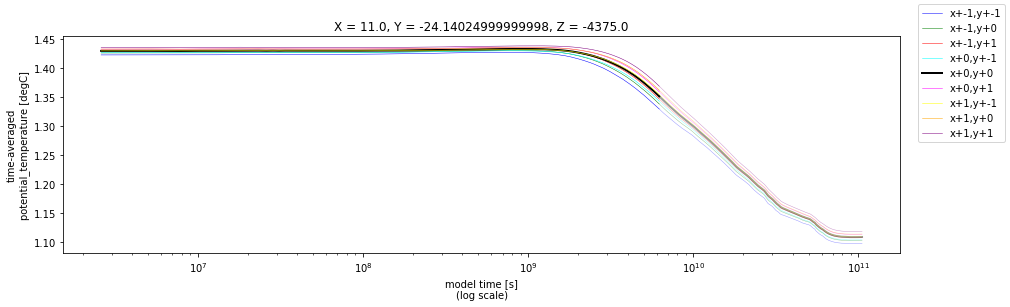

In [4]:
# Plot a timeseries of variable value at set grid point and its halo, 
# to use this to predict the value of that variable at a later time step

z=np.random.randint(1,40) # 42 points in z-dir - skip edge points, don't want to be near surface or bottom boundary *for now*.
x=np.random.randint(1,8)  # 11 points in x dir - skip edge points to allow non-boundary halo. Skip last 2 points, as last point is land
y=np.random.randint(1,75)  # 78 points in y dir - skip edge points to allow non-boundary halo. Skip last 2 points, as last point is land

colours=['blue' , 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'aquarmarine',
         'gold', 'brown', 'pink', 'grey', 'olive', 'yellowgreen', 'violet', 'teal', 'sienna',
         'salmon', 'plum', 'navy', 'orangered', 'tan', 'lightblue', 'khaki', 'indigo', 
         'darkgreen', 'crimson']
colours.insert(xy, 'black')
styles=['dotted'] * 28
styles.insert(xy, 'solid')
alphas=[0.4] * 28
alphas.insert(xy, 1.)
thicks=['0.5'] * 28
thicks.insert(xy, '2')

fig1 = plt.figure(figsize=(15,4))
i=0
for x_offset in halo_list:
    for y_offset in halo_list:
        ds_var[:split_index,z,y+y_offset,x+x_offset].plot(label=('x+%d,y+%d' % (x_offset, y_offset)), 
                                                          alpha=1.0, xscale='log', color=colours[i], lw=thicks[i])
        ds_var[split_index:,z,y+y_offset,x+x_offset].plot(alpha=0.4, xscale='log', color=colours[i], lw=thicks[i])
        plt.xlabel('model time [s]\n(log scale)')
        i=i+1

fig1.legend()
fig1.savefig('../regression_plots/'+my_var+'_'+str(x)+'.'+str(y)+'.'+str(z)+'.png')

Read in data as training and test data

In [5]:
inputs_tr = []
nxt_outputs_tr = []

inputs_te = []
nxt_outputs_te = []

# Read in as training and test data (rather than reading in all data and splitting),
# so we can learn on first n time steps, and test on rest

for z in range(1,40,10):
    for x in range(1,9,3):
        for y in range(1,76,10):
            for time in range(0, split_index, 20):
                inputs_tr.append([ds_var.isel(T=time)[z,y+y_offset,x+x_offset] for x_offset in halo_list for y_offset in halo_list])
                nxt_outputs_tr.append([ds_var.isel(T=time+StepSize)[z,y,x]])
                
            for time in range(split_index, len(ds.T.data)-StepSize, 200):
                inputs_te.append([ds_var.isel(T=time)[z,y+y_offset,x+x_offset] for x_offset in halo_list for y_offset in halo_list])
                nxt_outputs_te.append([ds_var.isel(T=time+StepSize)[z,y,x]])
                
inputs_tr=np.asarray(inputs_tr)
nxt_outputs_tr=np.asarray(nxt_outputs_tr)

inputs_te=np.asarray(inputs_te)
nxt_outputs_te=np.asarray(nxt_outputs_te)

##calculate outputs for tendancy model as the difference between 'next' and 'now'
tnd_outputs_tr = nxt_outputs_tr[:,0] - inputs_tr[:,xy]
tnd_outputs_te = nxt_outputs_te[:,0] - inputs_te[:,xy]

print(inputs_tr.shape, nxt_outputs_tr.shape, tnd_outputs_tr.shape)
print(inputs_te.shape, nxt_outputs_te.shape, tnd_outputs_te.shape)

(11520, 9) (11520, 1) (11520,)
(18432, 9) (18432, 1) (18432,)


Check the data by plotting a few random samples

2768
[9.697456 9.151742 8.665425 9.739385 9.187573 8.555028 9.887664 9.124408
 8.39599 ]
[9.187671]
9.727478e-05
12674
[6.0404067 6.020937  6.009018  6.034703  6.0288258 6.0282674 6.0451045
 6.050619  6.0565686]
[6.028852]


(0, 4)

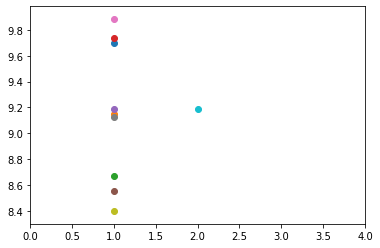

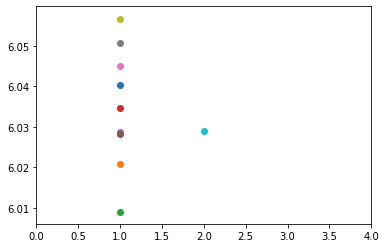

In [6]:
sample_no=np.random.randint(0,inputs_tr.shape[0])
print(sample_no)

print(inputs_tr[sample_no,:])
print(nxt_outputs_tr[sample_no])
print(tnd_outputs_tr[sample_no])

features = range(inputs_tr.shape[1])
fig = plt.figure()
ax=plt.subplot()
for feature in features:
    plt.scatter(1,inputs_tr[sample_no,feature])
plt.scatter(2,nxt_outputs_tr[sample_no])
#plt.scatter(3,tnd_outputs_tr[sample_no])
ax.set_xlim(0,4)

sample_no=np.random.randint(0,inputs_te.shape[0])
print(sample_no)
print(inputs_te[sample_no,:])
print(nxt_outputs_te[sample_no])
#print(tnd_outputs_te[sample_no])

features = range(inputs_te.shape[1])
fig = plt.figure()
ax=plt.subplot()
for feature in features:
    plt.scatter(1,inputs_te[sample_no,feature])
plt.scatter(2,nxt_outputs_te[sample_no])
#plt.scatter(3,tnd_outputs_te[sample_no])
ax.set_xlim(0,4)

Normalise Data

In [7]:
### Normalise (based on training data only)
def normalise_data(train,test):
    train_mean, train_std = np.mean(train), np.std(train)
    norm_train = (train - train_mean) / train_std
    norm_test  = (test - train_mean) / train_std
    return norm_train, norm_test

# normalise inputs
norm_inputs_tr = np.zeros(inputs_tr.shape)
norm_inputs_te = np.zeros(inputs_te.shape)

for i in range(inputs_tr.shape[1]):  #loop over each feature, normalising individually
    norm_inputs_tr[:, i], norm_inputs_te[:, i] = normalise_data(inputs_tr[:, i], inputs_te[:, i])

#normalise nxt and tnd outputs
norm_nxt_outputs_tr, norm_nxt_outputs_te = normalise_data(nxt_outputs_tr[:], nxt_outputs_te[:])
norm_tnd_outputs_tr, norm_tnd_outputs_te = normalise_data(tnd_outputs_tr[:], tnd_outputs_te[:])

# Calc mean and std of outputs re-forming predictions
nxt_outputs_tr_mean = np.mean(nxt_outputs_tr)
nxt_outputs_tr_std = np.std(nxt_outputs_tr)
tnd_outputs_tr_mean = np.mean(tnd_outputs_tr)
tnd_outputs_tr_std  = np.std(tnd_outputs_tr)

Set up a model to directly predict variable value at next time step

In [8]:
# First calculate and plot 'persistance' score, to give a baseline

predict_persistance_nxt = norm_inputs_te[:,xy]
print(predict_persistance_nxt.shape)

pers_nxt_r2 = r2_score(norm_nxt_outputs_te, predict_persistance_nxt)
pers_nxt_maxer = metrics.max_error(norm_nxt_outputs_te, predict_persistance_nxt)
pers_nxt_mse = metrics.mean_squared_error(norm_nxt_outputs_te, predict_persistance_nxt)

print('r2 score ; ', pers_nxt_r2)
print('max error ; ', pers_nxt_maxer)
print('mean squared error ; ', pers_nxt_mse)

(18432,)
r2 score ;  0.9999999691198818
max error ;  0.006014764308929443
mean squared error ;  3.0549434940561264e-08


In [9]:
# Tune alpha using cross validation, and neg mean squared error

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100]

parameters = [{'alpha': alpha_s}]
n_folds=5
scoring={'max_error', 'neg_mean_squared_error', 'r2'}

model_nxt=linear_model.Ridge()

# Calculate training scores using cross validation with various values of alpha
model_nxt_cv = GridSearchCV(model_nxt, parameters, cv=n_folds, scoring=scoring, refit='neg_mean_squared_error')
model_nxt_cv.fit(norm_inputs_tr, norm_nxt_outputs_tr)
results = model_nxt_cv.cv_results_

best_params=model_nxt_cv.best_params_
best_alpha = (best_params['alpha'])


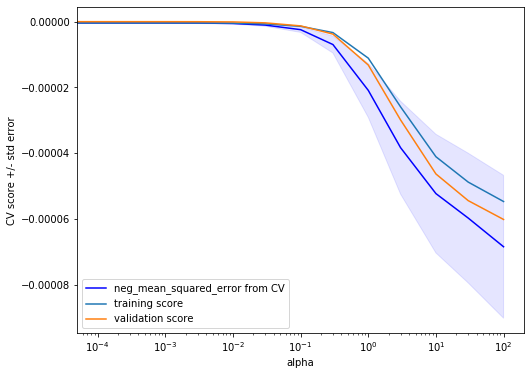

In [10]:
# For neg mean squared error, calculate and plot the mean score, and the region +/- one s.d
neg_mean_squared_error_mean = model_nxt_cv.cv_results_['mean_test_neg_mean_squared_error']
neg_mean_squared_error_std = model_nxt_cv.cv_results_['std_test_neg_mean_squared_error']
neg_mean_squared_error_std_error = neg_mean_squared_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, neg_mean_squared_error_mean, label='neg_mean_squared_error from CV', color='blue')
plt.fill_between(alpha_s, neg_mean_squared_error_mean + neg_mean_squared_error_std_error,
                 neg_mean_squared_error_mean - neg_mean_squared_error_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_nxt.set_params(alpha=alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(- metrics.mean_squared_error(norm_nxt_outputs_tr, model_nxt.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.mean_squared_error(norm_nxt_outputs_te, model_nxt.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

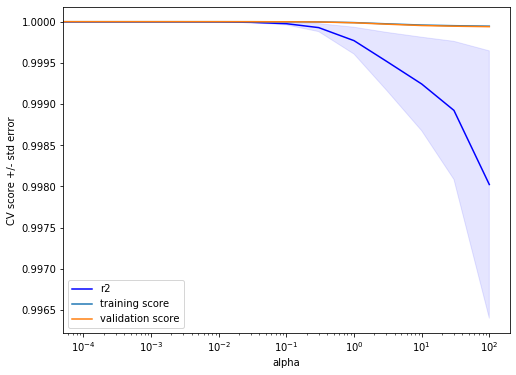

In [11]:
# For r2 score, calculate and plot the mean score, and the region +/- one s.d

r2_mean = model_nxt_cv.cv_results_['mean_test_r2']
r2_std = model_nxt_cv.cv_results_['std_test_r2']
r2_std_error = r2_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, r2_mean, label='r2', color='blue')
plt.fill_between(alpha_s, r2_mean + r2_std_error, r2_mean - r2_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_nxt.set_params(alpha=alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(model_nxt.score(norm_inputs_tr, norm_nxt_outputs_tr))
    val_scores.append(model_nxt.score(norm_inputs_te, norm_nxt_outputs_te))#
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

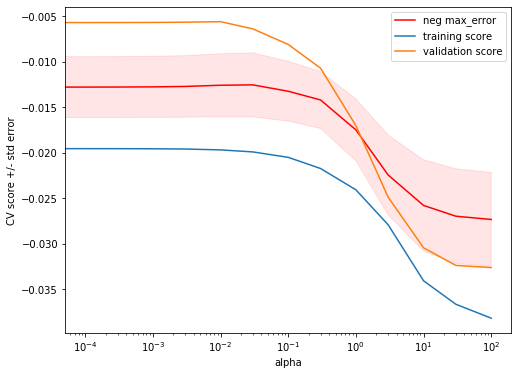

In [12]:
# For Max Error, plot the mean score, and the region +/- one s.d, (huge s.d. as you'd expect)
max_error_mean = model_nxt_cv.cv_results_['mean_test_max_error']
max_error_std = model_nxt_cv.cv_results_['std_test_max_error']
max_error_std_error = max_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, max_error_mean, label='neg max_error', color='red')
plt.fill_between(alpha_s, max_error_mean + max_error_std_error, max_error_mean - max_error_std_error, alpha=0.1, color='red')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_nxt.set_params(alpha=alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(- metrics.max_error(norm_nxt_outputs_tr, model_nxt.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.max_error(norm_nxt_outputs_te, model_nxt.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

Having Tuned Alpha set up and run model

In [13]:
#run model, predict next time step value, and assess, having selected a best alpha from above using mean-square scores

model_nxt= linear_model.Ridge(alpha=best_alpha)
# eventually might want to aim for a zero intercept, but model seems to struggle a lot with this so leave for now

model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr )  # train to evaluate the value at the next time step...

print('coefs     : ' + str(model_nxt.coef_))
print('intercept : ' + str(model_nxt.intercept_))
print(' ')

predicted_nxt = model_nxt.predict(norm_inputs_te)

nxt_r2 = r2_score(norm_nxt_outputs_te, predicted_nxt)
nxt_maxer = metrics.max_error(norm_nxt_outputs_te, predicted_nxt)
nxt_mse = metrics.mean_squared_error(norm_nxt_outputs_te, predicted_nxt)

print('r2 score ; ', nxt_r2)
print('max error ; ', nxt_maxer)
print('mean squared error ; ', nxt_mse)


coefs     : [[-0.00792534  0.01659487 -0.00832933  0.00269719  0.98646228  0.00916994
   0.00463733 -0.0019552  -0.00135081]]
intercept : [-1.58253195e-07]
 
r2 score ;  0.9999999659547739
max error ;  0.0056858565991848575
mean squared error ;  3.3680648853484654e-08


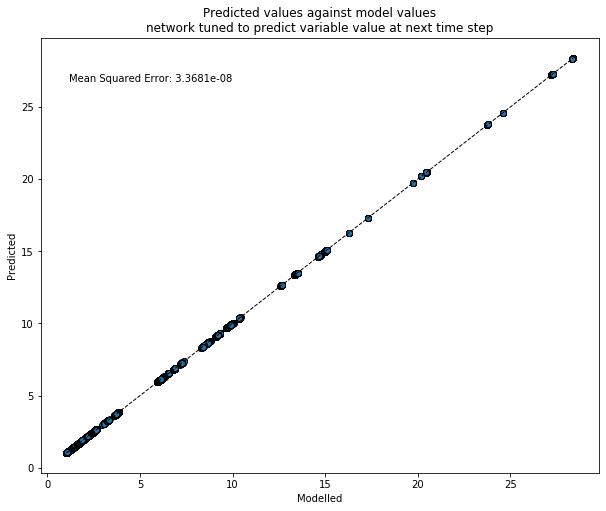

In [14]:
#de-normalise predicted values and plot against truth

denorm_predicted_nxt = predicted_nxt*nxt_outputs_tr_std+nxt_outputs_tr_mean

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(nxt_outputs_te, denorm_predicted_nxt, edgecolors=(0, 0, 0))
ax.plot([nxt_outputs_te.min(), nxt_outputs_te.max()], [nxt_outputs_te.min(), nxt_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Modelled')
ax.set_ylabel('Predicted')
ax.set_title('Predicted values against model values\nnetwork tuned to predict variable value at next time step')
ax.text(.05,.9,'Mean Squared Error: {:.4e}'.format(nxt_mse),transform=ax.transAxes)
plt.savefig('../regression_plots/'+my_var+'_predictedVtruth_nxt.png')
plt.show()

Define a new model to predict tendancy (difference between now and next step)

In [15]:
# A model to predict the tendancy in that variable (difference between now and next points)...

#normalise tendancy outputs
norm_tnd_outputs_tr, norm_tnd_outputs_te = normalise_data(tnd_outputs_tr[:], tnd_outputs_te[:])

# store these values to de-normalise
tnd_outputs_tr_mean = np.mean(tnd_outputs_tr)
tnd_outputs_tr_std  = np.std(tnd_outputs_tr)

In [18]:
# First calculate and plot 'persistance' score, to give a baseline

predict_persistance_tnd = np.zeros([tnd_outputs_te.shape[0]])

print('r2 score ; ', r2_score(norm_tnd_outputs_te, predict_persistance_tnd))
print('max error ; ', metrics.max_error(norm_tnd_outputs_te, predict_persistance_tnd))
print('mean squared error ; ', metrics.mean_squared_error(norm_tnd_outputs_te, predict_persistance_tnd))

r2 score ;  -6.169374930253824e-06
max error ;  9.26518726348877
mean squared error ;  0.07237963260102948


In [28]:
# Tune alpha using cross validation, and neg mean squared error

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100]

parameters = [{'alpha': alpha_s}]
n_folds=5
scoring={'max_error', 'neg_mean_squared_error', 'r2'}

model_tnd=linear_model.Ridge()

# Calculate training scores using cross validation with various values of alpha
model_tnd_cv = GridSearchCV(model_tnd, parameters, cv=n_folds, scoring=scoring, refit='r2')
model_tnd_cv.fit(norm_inputs_tr, norm_tnd_outputs_tr)
results = model_tnd_cv.cv_results_

best_params=model_tnd_cv.best_params_
best_alpha = (best_params['alpha'])


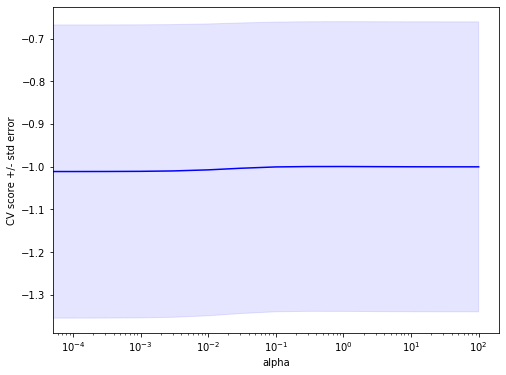

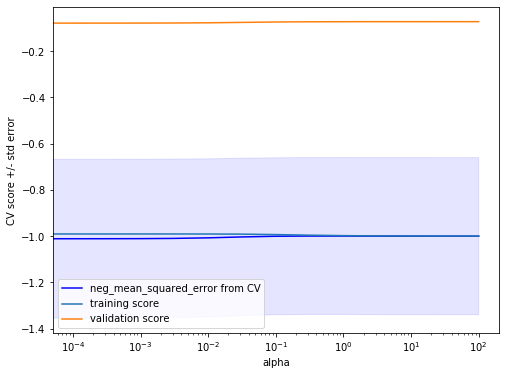

In [29]:
# For neg mean squared error, calculate and plot the mean score, and the region +/- one s.d
neg_mean_squared_error_mean = model_tnd_cv.cv_results_['mean_test_neg_mean_squared_error']
neg_mean_squared_error_std = model_tnd_cv.cv_results_['std_test_neg_mean_squared_error']
neg_mean_squared_error_std_error = neg_mean_squared_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, neg_mean_squared_error_mean, label='neg_mean_squared_error from CV', color='blue')
plt.fill_between(alpha_s, neg_mean_squared_error_mean + neg_mean_squared_error_std_error,
                 neg_mean_squared_error_mean - neg_mean_squared_error_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, neg_mean_squared_error_mean, label='neg_mean_squared_error from CV', color='blue')
plt.fill_between(alpha_s, neg_mean_squared_error_mean + neg_mean_squared_error_std_error,
                 neg_mean_squared_error_mean - neg_mean_squared_error_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_tnd.set_params(alpha=alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr)
    train_scores.append(- metrics.mean_squared_error(norm_tnd_outputs_tr, model_tnd.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.mean_squared_error(norm_tnd_outputs_te, model_tnd.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

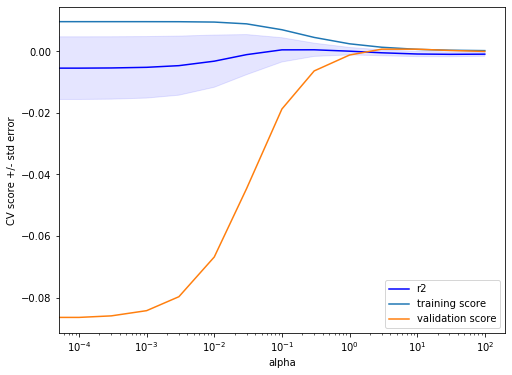

In [30]:
# For r2 score, calculate and plot the mean score, and the region +/- one s.d

r2_mean = model_tnd_cv.cv_results_['mean_test_r2']
r2_std = model_tnd_cv.cv_results_['std_test_r2']
r2_std_error = r2_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, r2_mean, label='r2', color='blue')
plt.fill_between(alpha_s, r2_mean + r2_std_error, r2_mean - r2_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_tnd.set_params(alpha=alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr)
    train_scores.append(model_tnd.score(norm_inputs_tr, norm_tnd_outputs_tr))
    val_scores.append(model_tnd.score(norm_inputs_te, norm_tnd_outputs_te))#
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

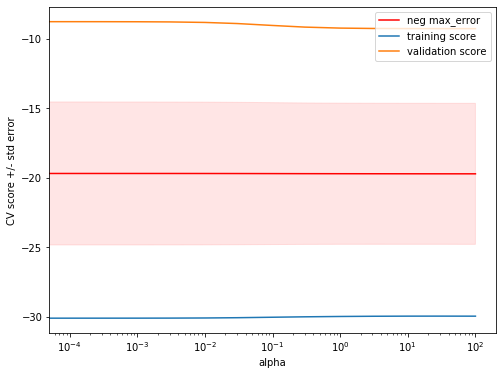

In [31]:
# For Max Error, plot the mean score, and the region +/- one s.d, (huge s.d. as you'd expect)
max_error_mean = model_tnd_cv.cv_results_['mean_test_max_error']
max_error_std = model_tnd_cv.cv_results_['std_test_max_error']
max_error_std_error = max_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, max_error_mean, label='neg max_error', color='red')
plt.fill_between(alpha_s, max_error_mean + max_error_std_error, max_error_mean - max_error_std_error, alpha=0.1, color='red')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_tnd.set_params(alpha=alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr)
    train_scores.append(- metrics.max_error(norm_tnd_outputs_tr, model_tnd.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.max_error(norm_tnd_outputs_te, model_tnd.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

Having Tuned Alpha set up and run model

In [32]:
#run model to predict next time step value, having selected a best alpha from above, using r2 scores

model_tnd= linear_model.Ridge(alpha=best_alpha)
# eventually might want to aim for a zero intercept, but model seems to struggle a lot with this so leave for now

model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr )  # train to evaluate the value at the next time step...

print('coefs     : ' + str(model_tnd.coef_))
print('intercept : ' + str(model_tnd.intercept_))
print(' ')

predicted_tnd = model_tnd.predict(norm_inputs_te)
tnd_r2 = r2_score(norm_tnd_outputs_te, predicted_tnd)
tnd_maxer = metrics.max_error(norm_tnd_outputs_te, predicted_tnd)
tnd_mse = metrics.mean_squared_error(norm_tnd_outputs_te, predicted_tnd)

print('r2 score ; ', tnd_r2)
print('max error ; ', tnd_maxer)
print('mean squared error ; ', tnd_mse)


coefs     : [-3.18743846  5.54186365 -1.50950375 -0.40096704 -2.23991237  0.43065619
  2.71308479 -1.63314965  0.27759986]
intercept : 3.720344315383063e-07
 
r2 score ;  -0.006418837120000687
max error ;  9.151672483102692
mean squared error ;  0.07284377627293383


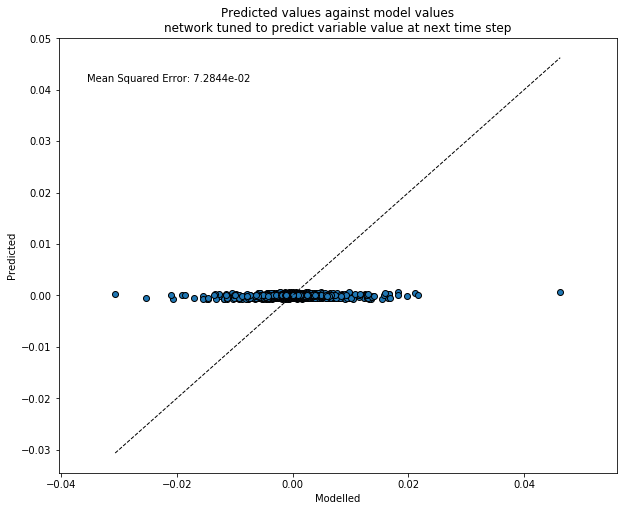

In [33]:
#de-normalise predicted values and plot against truth

denorm_predicted_tnd = predicted_tnd*tnd_outputs_tr_std+tnd_outputs_tr_mean

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(tnd_outputs_te, denorm_predicted_tnd, edgecolors=(0, 0, 0))
ax.plot([tnd_outputs_te.min(), tnd_outputs_te.max()], [tnd_outputs_te.min(), tnd_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Modelled')
ax.set_ylabel('Predicted')
ax.set_title('Predicted values against model values\nnetwork tuned to predict variable value at next time step')
ax.text(.05,.9,'Mean Squared Error: {:.4e}'.format(tnd_mse),transform=ax.transAxes)
plt.savefig('../regression_plots/'+my_var+'_predictedVtruth_tnd.png')
plt.show()

Attempts to bug fix code - something is wrong as test data always performs better than training data....?!?!

In [25]:
# Results are suspicious... validation score should be worse than test, and should increase with alpha...
# possible its due to the organised separation of test and train... investigate by combining train 
# and test data and then randomly separating and running...

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

inputs = np.vstack((norm_inputs_tr, norm_inputs_te))
outputs = np.vstack((norm_nxt_outputs_tr, norm_nxt_outputs_te))
data = np.hstack((inputs, outputs))
np.random.shuffle(data)

#Split data into two sets
in_set1, in_set2, out_set1, out_set2 = train_test_split(data[:,0:8], data[:,9:] , test_size=0.2, random_state=0)


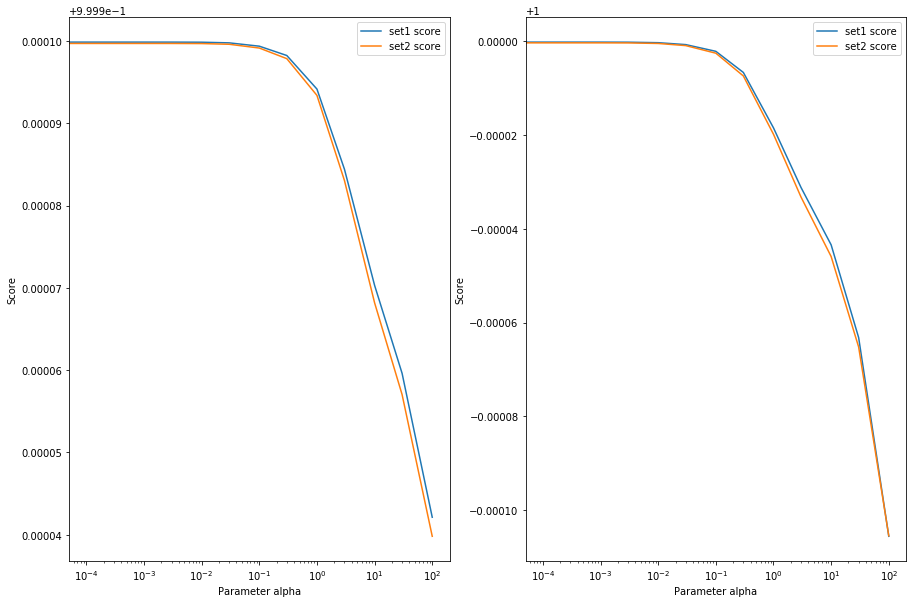

[-3.0825419994329195e-09, -3.1941207456753773e-09, -3.5230484085602143e-09, -5.7114872831220964e-09, -1.9284270735830944e-08, -1.1303077285251817e-07, -4.439985428206228e-07, -1.4743484627599557e-06, -4.850030008829442e-06, -1.2600433347609297e-05, -1.5575775439313766e-05, -1.3717159514259336e-05, -2.2812610537381595e-05, -4.774276480734585e-05]
[3.1067534100870375e-09, 3.0677953510860334e-09, 2.8699331799941774e-09, 9.991547589294214e-10, -1.2705499430332168e-08, -1.1453983117526434e-07, -4.880832189524398e-07, -1.647332192433737e-06, -5.214618587601194e-06, -1.3202168798631675e-05, -1.6244153244193704e-05, -1.4086033144344867e-05, -2.2244927974979234e-05, -4.532785061495126e-05]


In [26]:
alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100]

#Run with set1 used as training data
set1_test1 = []
set2_test1 = []
for alpha in alpha_s:
    model_test1 = linear_model.Ridge(alpha=alpha)
    # eventually might want to aim for a zero intercept, but model seems to struggle a lot with this so leave for now
    # Fit model based on training data (and alpha)
    model_test1.fit(in_set1, out_set1)
    set1_test1.append(model_test1.score(in_set1, out_set1))
    set2_test1.append(model_test1.score(in_set2, out_set2))
# Do the plotting
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.semilogx(alpha_s, set1_test1, label='set1 score')
plt.semilogx(alpha_s, set2_test1, label='set2 score')
plt.ylabel('Score')
plt.xlabel('Parameter alpha')
plt.legend()

#Redo with set2 used as training data
set1_test2 = []
set2_test2 = []
for alpha in alpha_s:
    model_test2 = linear_model.Ridge(alpha=alpha)
    # Fit model based on *test* data (and alpha)
    model_test2.fit(in_set2, out_set2)
    set1_test2.append(model_test2.score(in_set1, out_set1))
    set2_test2.append(model_test2.score(in_set2, out_set2))
# Do the plotting
plt.subplot(122)
plt.semilogx(alpha_s, set1_test2, label='set1 score')
plt.semilogx(alpha_s, set2_test2, label='set2 score')
plt.ylabel('Score')
plt.xlabel('Parameter alpha')
plt.legend()

plt.show()

print([a_i - b_i for a_i, b_i in zip(set1_test2,set1_test1)])
print([a_i - b_i for a_i, b_i in zip(set2_test2,set2_test1)])

In [27]:
model_CV=linear_model.RidgeCV(alphas=alpha_s[1:]).fit(in_set1, out_set1)

print(model_CV.score(in_set1, out_set1))
print(model_CV.score(in_set2, out_set2))
print( )
model_CV=linear_model.RidgeCV(alphas=alpha_s[1:]).fit(in_set2, out_set2)

print(model_CV.score(in_set1, out_set1))
print(model_CV.score(in_set2, out_set2))

0.9999998513465097
0.9999996870717903

0.9999998481684913
0.9999996901760936
